In [2]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
%matplotlib

from tqdm import tqdm

Using matplotlib backend: nbAgg


# Data Dictionary
- remember there is no data for last order per customer

#### orders (415k rows): fact table, one record per order, includes useful time dimensions
- order_id: order identifier
- user_id: customer identifier
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- Order_hour_of_day: hour of day the order was placed
- Days_since_prior_order: Number of days since that customer placed their previous order (NA for order_number = 1)

#### order_products (3.9M rows): fact table, one record per order, per product
_except for last order by a customer_
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

#### products (50k rows): Dimension table for product info
- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

#### aisles (134 rows): Dimension table for aisle info
- aisle_id: aisle identifier
- aisle: the name of the aisle

#### departments (21 rows): Dimension table for department info
- department_id: department identifier
- department: the name of the department


In [3]:
engine = sql.create_engine('sqlite:///instacart.db')
db = {}

In [4]:
for table in ['orders', 'order_products', 'products', 'aisles', 'departments',]:
    db[table] = pd.read_sql_table(table, engine, index_col=0,)

In [5]:
# aliases
orders = db['orders']
orders.set_index('order_id', inplace=True)

ops = db['order_products']   # default index vs. multi-index on order_id + add_to_cart_order

products = db['products']
del(products['index'])       # index is one off from xxxx_id, confusing
products.set_index('product_id', inplace=True)

del(db['departments']['index'])
db['departments'].set_index('department_id', inplace=True)

del(db['aisles']['index'])
db['aisles'].set_index('aisle_id', inplace=True)

In [6]:
products_by_aisle = products.groupby('aisle_id')
products_by_dept = products.groupby('department_id')
get_dept_from_aisle = products_by_aisle['department_id'].unique()

In [ ]:
get_aisles_from_dept = products_by_dept['aisle_id'].unique()

In [ ]:
# confirm correspondence:
dept = 1
for aisle in get_aisles_from_dept[dept]:
    assert get_dept_from_aisle[aisle] == [dept]

In [ ]:
len(orders)

In [ ]:
orders.index[14]  # no data in ops

In [ ]:
orders.head(16)

In [ ]:
# note for me - series.value_counts() is nice
ops.groupby('product_name').size().sort_values(ascending=False)[:10]
ops.product_name.value_counts()[:10]

# Product segmentation

### Can products be separated into groups?
- the store they come from
- the customers who buy them
- properties? i.e. name, department, aisle?
- the products that they are co-ordered with

Hypothesis 1:
Orders come from discrete retailers; product assortment will be largely or entirely separate depending on store.

Test method:
Build a graph of all products. Products will be connected to other products that they share an order with, this will determine whether there are entirely disjoint sections of product graph

In [7]:
ops = pd.merge(ops, products, left_on='product_id', right_index=True).sort_values('order_id')   
# add product details to order_products: name, aisle_id, department_id 

In [8]:
real_products = set(ops.product_id.unique())   # there are products in db['products'] that are not in any orders
len(real_products)

42814

In [9]:
products['product_id'] = products.index.values  # can't apply function to index, so duplicate it

In [10]:
from collections import defaultdict

'''
ProductGraph provides a measure of distance between products based on number of
orders in which A,B overlap.
Note that this is NOT a measure of similarity, i.e. bananas and bag-of-bananas are
likely far apart.
Low distance <-> high likelihood of overlap
'''

class ProductGraph:
    def __init__(self, order_records):
        # order_records[i] => {items in order i}
        # i.e. a groupby object
        self.records = order_records.groupby('order_id')['product_id'].unique()
        
        # graph is from a product to other products that are connected by an order
        # graph[A] = {B: number of orders containing both A & B}
        self.graph = {i: defaultdict(int) for i in order_records.product_id.unique()}
        
        # order_records.product_id.value_counts()[]
        self.orders_for_product = order_records.product_id.value_counts()
        
    def add_order_items(self, order_items):
        # add a collection of items to network;
        # each connection is incremented by one
        # order n^2 but only has to run once...
        for active_item in order_items:
            for second_item in [item for item in order_items if item != active_item]:
                self.graph[active_item][second_item] += 1
                
    def add_order_number(self, order_number):
        order_items = self.records[order_number]
        self.add_order_items(order_items)
        
    def build_graph(self):
        for order_no in tqdm(self.records.index):
            self.add_order_number(order_no)
            
    def find_all_connections_from(self, start_node):
        # search on graph to find indirectly-connected products
        q = []
        q.append(start_node)
        visited = set()
        while q:
            node = q.pop()  # node we are on
            if node in visited:
                continue
            else:
                visited.add(node)
                for key in self.graph[node].keys():
                    q.append(key)
        return visited
        
    def distance(self, node_1, node_2, oddity=.75):
        # distance from 1 to 2, with oddity factor so it's not all bananas
        # increasing oddity devalues popular products
        # not normalized
        connections = self.graph[node_1][node_2]
        if node_1 == node_2:
            return 0
        elif connections:
            pop = self.orders_for_product[node_2]**oddity
            return pop / connections
        else:
            return 1000

In [11]:
g = ProductGraph(ops)  # slow-ish, runs 2 groupby operations 

In [12]:
g.build_graph()

100%|██████████| 389772/389772 [01:01<00:00, 6293.16it/s]


In [ ]:
# time savers while rebuilding
# g.graph = save
# save = g.graph

### Hypothesis - discrete retailers:

False. Graph of products is fully connected (at some depth), except for products that have only been ordered singly.

In [ ]:
connected_to_ = g.find_all_connections_from(2)

In [ ]:
print(len(connected_to_))
# fully connected graph except for products only purchased alone

In [ ]:
singletons = [p for p in real_products if p not in connected_to_]

In [ ]:
len(singletons)

In [ ]:
connected_to_ = None
products.loc[singletons[:10]]  # weirdo product

### Now we have something like a distance metric!

# Let's see how it does

We can pick out the closest product to a basket. This may be a reasonable guess for something a customer would buy.

### Hypothesis:

The value of recommending a product is inversely proportional to the popularity of that product to some power <= 1.

Bananas will often have the highest number of shared orders with a product, but it seems that bananas are not the best recommendation to make in all cases.

Consider niche product X.
Of a million people who bought bananas, some will buy X. This reflects more on the ubiquity of bananas than a strong affinity of banana buyers to product X.

Although a percentage of buyers of X will go on to buy bananas, there are probably higher-value recommendations available.

In [ ]:
ops.product_id.value_counts()[:3]   # ID, number of orders

In [ ]:
banana = 24852
org_bananas = 13176
org_strawberries = 21137
almond_milk = 432
products.product_name.loc[almond_milk]

In [ ]:
g.distance(org_strawberries, org_bananas)

In [ ]:
g.distance(org_strawberries, banana)

In [ ]:
g.distance(org_bananas, almond_milk)

In [ ]:
g.distance(banana, almond_milk)

In [ ]:
g.distance(almond_milk, banana)

In [ ]:
g.distance(almond_milk, 10957)

In [16]:
top_products = ops.product_id.value_counts().keys()[:5000]  # most popular items

In [ ]:
def recommend(order_items, dist=g.distance, options=top_products, oddity=.75):
    '''
    take a list of order items; compute distance using ProductGraph.distance
    return most likely additions from top 1000 products
    '''
    best_item = None
    best_score = 1000000
    for option in options:
        option_score = 0
        for my_item in order_items:
            if my_item == option:
                option_score = pd.np.NaN
            else:
                score = dist(my_item, option, oddity=oddity)
                option_score += score  # arbitrary similarity metric discounts popular products
        if option_score < best_score:
            best_score = option_score
            best_item = option
    return best_item, best_score

In [ ]:
recommend(products_in_order[2])

In [ ]:
def generate_recs(i):
    try:
        basket = g.records[orders.index[i]]
        last = basket[-1]
        basket = basket[:-1]
    except KeyError:
        print('order_id {} exists in orders.index, but contains no items. \n'.format(orders.index[i]))
        return None
    
    print('\n' + '+ ' * 30 + '\n')
    print(products.loc[basket].product_name)

    for oddity in [0, .5, .7, 1, 1.5]:
        print('\n oddity factor: {}'.format(oddity))
        item, score = recommend(basket, oddity=oddity)
        if item:
            print(products.loc[item].product_name)
        
    print()
    print('actual final item: {}'.format(products.loc[last].product_name))
        
    print()
    return item

In [ ]:
for _ in range(5):
    o = pd.np.random.randint(0, 100000)
    generate_recs(o)

### Re: Hypothesis

There is some support for an inverse factor for item popularity, so let's stick with that.

# Use distance metric to find a coordinate system for products

By finding distance from a subset of products to all products, we will have multiple 'dimensions' that could be used for PCA, finding a coordinate system for products.

In [13]:
mask = [True if p in real_products else False for p in products.index]

In [14]:
len(products[mask])

42814

In [15]:
real_products = products[mask].copy()

In [24]:
rows = len(real_products)

for col in tqdm(range(300)):
    prod_index = pd.np.random.randint(0, len(top_products))
    product = top_products[prod_index]
    col_name = 'dist_{}'.format(str(product))
    
    reference = real_products.product_id.loc[product]
    d = [g.distance(real_products.index[i], reference)/1000 for i in range(rows)]
    real_products[col_name] = d
        

100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


In [23]:
real_products.columns

Index(['product_name', 'aisle_id', 'department_id', 'product_id', 'dist_45938',
       'dist_24413', 'dist_16254', 'dist_9203', 'dist_6510', 'dist_17313',
       ...
       'dist_20842', 'dist_43087', 'dist_17619', 'dist_8382', 'dist_46984',
       'dist_3874', 'dist_8803', 'dist_8574', 'dist_33957', 'dist_34262'],
      dtype='object', length=577)

# Now we have distances (from arbitrary points)

Can we use PCA to find a coordinate system that describes the space?

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=10)

In [27]:
pca.fit(real_products.iloc[:, 5:].values)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [51]:
xyz = pca.transform(real_products.iloc[:, 5:].values)
xyz.shape

(42814, 10)

In [29]:
db['departments'].department

department_id
1              frozen
2               other
3              bakery
4             produce
5             alcohol
6       international
7           beverages
8                pets
9     dry goods pasta
10               bulk
11      personal care
12       meat seafood
13             pantry
14          breakfast
15       canned goods
16         dairy eggs
17          household
18             babies
19             snacks
20               deli
21            missing
Name: department, dtype: object

<IPython.core.display.Javascript object>


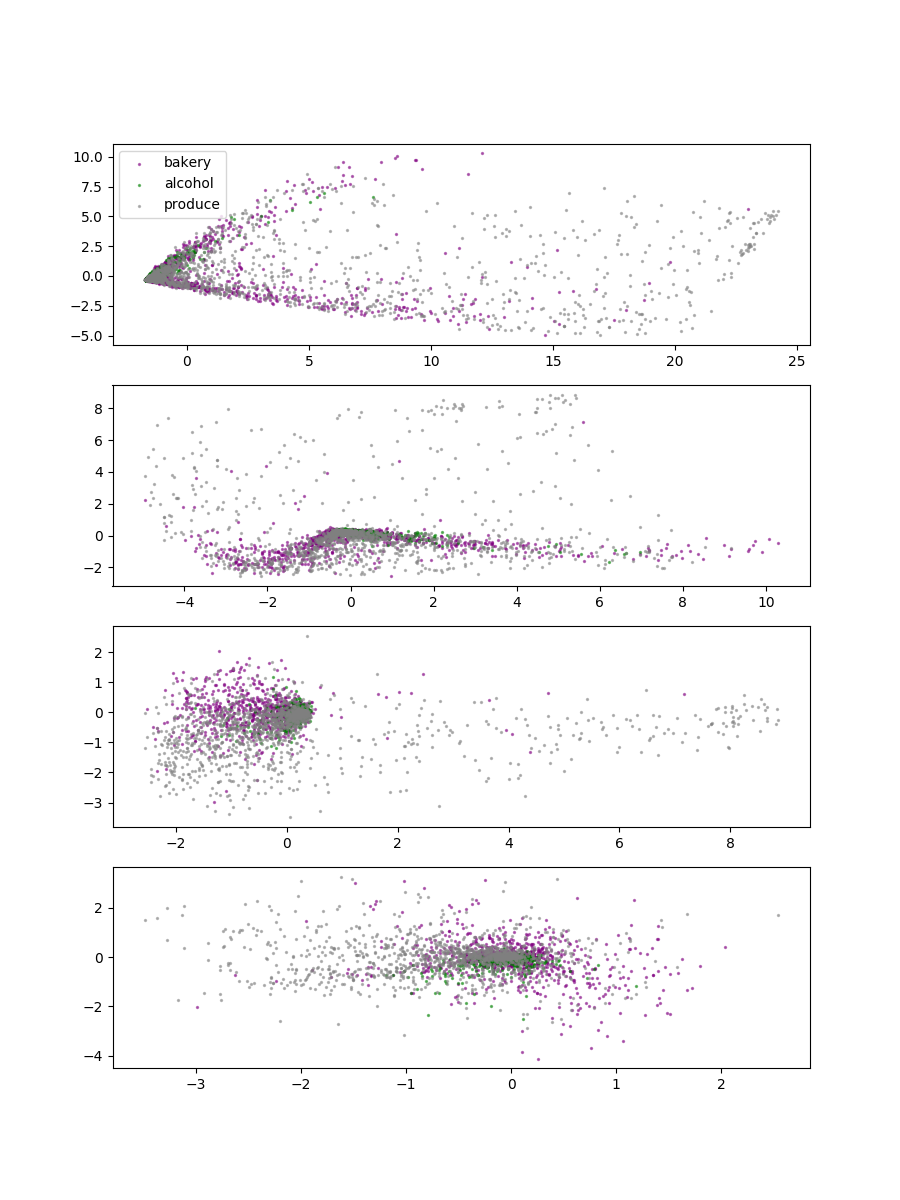

In [32]:
d1 = 3
d2 = 5
d3 = 4
groups = [(d1, 'purple'), (d2, 'green'), (d3, 'gray')]

num=40000
rows = 4

fig, ax = plt.subplots(nrows=rows)
fig.set_size_inches(9, 12)

for i in range(rows):
    for series, color in groups:
        mask = real_products.department_id == series
        label = db['departments'].department.loc[series]
        ax[i].scatter(x=xyz[mask.values][:num, i], y=xyz[mask.values][:num, i+1], 
                      c=color,
                      alpha=.5,
                      s=2,
                      label=label,
                      )
    
ax[0].legend()

In [72]:
def get_distance(start_id, finish_id, v=0):
    # get cartesian distance between two points in PCA space
    if v:
        print(real_products.product_name.loc[start_id])
        print(real_products.product_name.loc[finish_id])
    xyz1 = pca.transform(real_products.loc[start_id].values[5:].reshape(1, -1))
    xyz2 = pca.transform(real_products.loc[finish_id].values[5:].reshape(1, -1))
    diff = xyz1 - xyz2
    return pd.np.dot(diff, diff.T)[0, 0]

In [86]:
best_score = 100000
best_product = None
out = []

item = 32
print(real_products.product_name.loc[item])

for i in tqdm(range(49000)):

    if i == item:
        continue
    try: 
        score = get_distance(item, i)
        if score < best_score:
            best_score = score
            best_product = i
            out.append((best_product, best_score, i))
    except KeyError:
        continue
        
for el in out:
    print(real_products.product_name.loc[el[0]], el[1], el[2])

  0%|          | 51/49000 [00:00<01:36, 509.12it/s]

Nacho Cheese White Bean Chips


100%|██████████| 49000/49000 [01:08<00:00, 717.58it/s]

Chocolate Sandwich Cookies 24.20700860882647 1
All-Seasons Salt 12.493193811306114 2
Robust Golden Unsweetened Oolong Tea 11.377591168205203 3
Organic Turkey Burgers 4.960203826839986 23
Local Living Butter Lettuce 2.4872450937321875 99
Wild Blueberry All Natural Fruit Spread 2.46417835234108 149
Gluten Free Oatmeal, Variety Pack 2.258488778961258 216
Brooklyn Pizza Dough 1.3817647080902262 322
Vegan Shells & Creamy Sauce Mac & Cheese Macaroni & Cheese Organic 0.9368674484418446 671
Crunchy Kale, Naked 0.748803396769276 2087
Organic Maple & Onion Baked Beans 0.5466978149620586 2116
S'mores Ice Cream 0.3588471622963323 36029


In [131]:
get_distance(31, 16797, v=1)

White Pearl Onions
Strawberries


756.8702571097732

In [194]:
def vector_distance(item):
    print('best match for:', real_products.product_name.loc[item])
    ind = real_products.index.get_loc(item)
    # print(ind)
    my_coords = pca.transform(real_products.loc[item].values[5:].reshape(1, -1))
    
    diff = xyz - my_coords
    scores = pd.np.linalg.norm(diff, axis=1)
    scores[ind] = pd.np.Inf

    best = pd.np.argmin(scores)
    return real_products.product_name.iloc[best], real_products.index[best], pd.np.min(scores)

In [209]:
vector_distance(4)

best match for: Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce


('Chunky Blue Cheese Dressing', 34955, 0.376639527814384)